#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 16
**CH16A Predicting apartment prices with random forest**

using the airbnb dataset

version 0.92 2021-07-05


### NOTE: THIS IS NEW MATERIAL, NOT YET IN THE TEXTBOOK

In [1]:
import math
import os
import sys
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import PercentFormatter
from patsy import dmatrices
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.inspection import partial_dependence, permutation_importance
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings("ignore")

In [2]:
path = Path(os.getcwd())

base_dir = str(path.parent.parent)

data_in = os.path.join(base_dir, "da_case_studies/ch16-airbnb-random-forest/")
data_out = os.path.join(base_dir, "da_case_studies/ch16-airbnb-random-forest/")
output = os.path.join(base_dir, "da_case_studies/ch16-airbnb-random-forest/output/")
func = os.path.join(base_dir, "da_case_studies/ch00-tech-prep/")

sys.path.append(func)
from py_helper_functions import *

sns.set_theme(rc=da_theme, palette=color)


## PART I
### Loading and preparing data 
----------------------------------------------

In [3]:
# !!! make sure you have run ch16-airbnb-prepare-london.ipynb before
area = "london"
data = pd.read_csv(data_in + "airbnb_" + area + "_workfile_adj.csv")
data = data.loc[data.price.notna(), :]


In [4]:
def count_missing_values(df):
    return df.isna().sum()[df.isna().sum() > 0]


In [ ]:
count_missing_values(data)


Series([], dtype: int64)

In [6]:
# Sample definition and preparation ---------------------------------------

# We focus on normal apartments, n<8
data = data.loc[lambda x: x["n_accommodates"] < 8]


In [7]:
# copy a variable - purpose later, see at variable importance
data = data.assign(n_accommodates_copy=data.n_accommodates)


In [ ]:
# basic descr stat -------------------------------------------
data.describe()


,usd_price_day,n_accommodates,n_bathrooms,n_review_scores_rating,n_number_of_reviews,n_guests_included,n_reviews_per_month,n_extra_people,n_minimum_nights,n_beds,...,flag_review_scores_rating,flag_reviews_per_month,flag_n_number_of_reviews,ln_days_since,ln_days_since2,ln_days_since3,n_days_since2,n_days_since3,ln_review_scores_rating,n_accommodates_copy
count,49826.000000,49826.000000,49826.000000,49826.000000,49826.000000,49826.000000,49826.000000,49826.00000,49826.000000,49826.000000,...,49826.000000,49826.000000,49826.0,49826.000000,49826.000000,49826.000000,4.982600e+04,4.982600e+04,49826.000000,49826.000000
mean,88.984044,2.838759,1.224260,92.458616,12.340144,1.356180,1.138253,6.50873,3.300947,1.585959,...,0.318850,0.303998,0.0,5.713297,33.456371,199.607207,2.931985e+05,3.046539e+08,4.520910,2.838759
std,70.515089,1.494748,0.466448,8.418474,25.889935,0.879263,1.238156,12.31549,29.578062,0.927501,...,0.466035,0.459986,0.0,0.902564,9.506988,80.264045,5.640361e+05,9.636140e+08,0.120421,1.494748
min,8.000000,1.000000,0.000000,20.000000,0.000000,1.000000,0.010000,0.00000,1.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,2.995732,1.000000
25%,41.000000,2.000000,1.000000,92.000000,0.000000,1.000000,0.470000,0.00000,1.000000,1.000000,...,0.000000,0.000000,0.0,5.433722,29.525335,160.432461,5.198400e+04,1.185235e+07,4.521789,2.000000
50%,70.000000,2.000000,1.000000,94.000000,3.000000,1.000000,0.770000,0.00000,2.000000,1.000000,...,0.000000,0.000000,0.0,5.793014,33.559007,194.407782,1.069290e+05,3.496578e+07,4.543295,2.000000
75%,110.000000,4.000000,1.000000,97.000000,12.000000,1.000000,1.170000,10.00000,3.000000,2.000000,...,1.000000,1.000000,0.0,6.224558,38.745128,241.171311,2.540160e+05,1.280241e+08,4.574711,4.000000
max,999.000000,7.000000,8.000000,100.000000,396.000000,16.000000,15.000000,240.00000,5000.000000,16.000000,...,1.000000,1.000000,0.0,7.909489,62.560024,494.817853,7.409284e+06,2.016807e+10,4.605170,7.000000


In [9]:
data.price.describe()


count    49826.000000
mean        88.984044
std         70.515089
min          8.000000
25%         41.000000
50%         70.000000
75%        110.000000
max        999.000000
Name: price, dtype: float64

In [10]:
data.f_room_type.value_counts()


f_room_type
Entire home/apt    24938
Private room       24351
Shared room          537
Name: count, dtype: int64

In [11]:
data.f_property_type.value_counts()


f_property_type
Apartment    37467
House        12359
Name: count, dtype: int64

In [12]:
data.f_number_of_reviews.value_counts()


f_number_of_reviews
1    31576
0    15147
2     3103
Name: count, dtype: int64

In [13]:
# create train and holdout samples -------------------------------------------
# train is where we do it all, incl CV

# First pick a smaller than usual training set so that models run faster and check if works
# If works, start anew without these two lines


In [14]:
data_train, data_holdout = train_test_split(data, train_size=0.7, random_state=42)


In [15]:
data_train.shape, data_holdout.shape


((34878, 92), (14948, 92))

In [16]:
# Basic Variables inc neighnourhood
basic_vars = [
    "n_accommodates",
    "n_beds",
    "n_days_since",
    "f_property_type",
    "f_room_type",
    "f_bathroom",
    "f_cancellation_policy",
    "f_bed_type",
    "f_neighbourhood_cleansed",
]

# reviews
reviews = [
    "n_number_of_reviews",
    "flag_n_number_of_reviews",
    "n_review_scores_rating",
    "flag_review_scores_rating",
]

# Dummy variables
amenities = [col for col in data if col.startswith("d_")]

# interactions for the LASSO
# from ch14
X1 = [
    "n_accommodates:f_property_type",
    "f_room_type:f_property_type",
    "f_room_type:d_familykidfriendly",
    "d_airconditioning:f_property_type",
    "d_cats:f_property_type",
    "d_dogs:f_property_type",
]
# with boroughs
X2 = [
    "f_property_type:f_neighbourhood_cleansed",
    "f_room_type:f_neighbourhood_cleansed",
    "n_accommodates:f_neighbourhood_cleansed",
]

In [17]:
predictors_1 = basic_vars
predictors_2 = basic_vars + reviews + amenities
predictors_E = basic_vars + reviews + amenities + X1 + X2


In [18]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

Create sklearn preprocessor for encoding categorical variables to dummies

In [19]:
preprocessor = ColumnTransformer(
    [
        ("cat", OneHotEncoder(), categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

In [20]:
X = preprocessor.fit_transform(data_train[predictors_2])
X = pd.DataFrame(X, columns=preprocessor.get_feature_names_out())
y = data_train["price"]

## PART II
### RANDOM FORESTS 
-------------------------------------------------------

**Note:** n_estimators=500 in the R code.

Here, we set it to 30 because the model runs mutch faster, and this does not change the results substantively here – however in other cases might.

In [21]:
# NOTE: set number of cores you want to run models
ncores = 7


In [22]:
rfr = RandomForestRegressor(
    random_state=42,
    criterion="squared_error",
    n_estimators=30,
    oob_score=True,
    n_jobs=ncores,
)

tune_grid = {"max_features": [5, 7, 9], "min_samples_split": [6, 11]}

rf_random = GridSearchCV(
    rfr, tune_grid, cv=5, scoring="neg_root_mean_squared_error", verbose=3
)

rf_model_1 = rf_random.fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END max_features=5, min_samples_split=6;, score=-45.770 total time=   0.2s
[CV 2/5] END max_features=5, min_samples_split=6;, score=-44.743 total time=   0.2s
[CV 3/5] END max_features=5, min_samples_split=6;, score=-45.372 total time=   0.2s
[CV 4/5] END max_features=5, min_samples_split=6;, score=-42.855 total time=   0.2s
[CV 5/5] END max_features=5, min_samples_split=6;, score=-46.037 total time=   0.2s
[CV 1/5] END max_features=5, min_samples_split=11;, score=-46.323 total time=   0.2s
[CV 2/5] END max_features=5, min_samples_split=11;, score=-45.266 total time=   0.2s
[CV 3/5] END max_features=5, min_samples_split=11;, score=-45.699 total time=   0.2s
[CV 4/5] END max_features=5, min_samples_split=11;, score=-43.529 total time=   0.2s
[CV 5/5] END max_features=5, min_samples_split=11;, score=-46.304 total time=   0.2s
[CV 1/5] END max_features=7, min_samples_split=6;, score=-45.339 total time=   0.2s
[CV 2/5] EN

In [23]:
rfr = RandomForestRegressor(
    random_state=42,
    criterion="squared_error",
    n_estimators=30,
    oob_score=True,
    n_jobs=ncores,
)

tune_grid = {
    "max_features": [8, 10, 12],
    "min_samples_split": [6, 11, 16],
}

rf_random = GridSearchCV(
    rfr,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)

rf_model_2 = rf_random.fit(X, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END max_features=8, min_samples_split=6;, score=-45.465 total time=   0.2s
[CV 2/5] END max_features=8, min_samples_split=6;, score=-44.533 total time=   0.2s
[CV 3/5] END max_features=8, min_samples_split=6;, score=-44.663 total time=   0.2s
[CV 4/5] END max_features=8, min_samples_split=6;, score=-42.604 total time=   0.3s
[CV 5/5] END max_features=8, min_samples_split=6;, score=-45.639 total time=   0.2s
[CV 1/5] END max_features=8, min_samples_split=11;, score=-44.982 total time=   0.2s
[CV 2/5] END max_features=8, min_samples_split=11;, score=-44.633 total time=   0.2s
[CV 3/5] END max_features=8, min_samples_split=11;, score=-44.953 total time=   0.2s
[CV 4/5] END max_features=8, min_samples_split=11;, score=-42.818 total time=   0.2s
[CV 5/5] END max_features=8, min_samples_split=11;, score=-45.942 total time=   0.2s
[CV 1/5] END max_features=8, min_samples_split=16;, score=-45.475 total time=   0.2s
[CV 2/5] E

### Table 16.1 Random forest RMSE by tuning parameters

In [24]:
(
    pd.DataFrame(rf_model_2.cv_results_)[
        ["param_max_features", "param_min_samples_split", "mean_test_score"]
    ]
    .assign(
        mean_test_score=lambda x: x["mean_test_score"] * -1,
        Variables=lambda x: x["param_max_features"],
        Min_nodes=lambda x: x["param_min_samples_split"] - 1,
    )
    .pivot(index="Min_nodes", columns="Variables", values="mean_test_score")
    .round(2)
)

Variables,8,10,12
Min_nodes,,,
5,44.58,44.48,44.27
10,44.67,44.58,44.36
15,44.83,44.63,44.47


In [25]:
pd.DataFrame(
    {
        "Min vars": [
            rf_model_1.best_estimator_.max_features,
            rf_model_2.best_estimator_.max_features,
        ],
        "Min nodes": [
            rf_model_1.best_estimator_.min_samples_split - 1,
            rf_model_2.best_estimator_.min_samples_split - 1,
        ],
    },
    ["Model A", "Model B"],
)


,Min vars,Min nodes
Model A,9,5
Model B,12,5


In [26]:
rf_model_1_rmse = rf_model_1.cv_results_["mean_test_score"].max() * -1
rf_model_2_rmse = rf_model_2.cv_results_["mean_test_score"].max() * -1

pd.DataFrame(
    {"RMSE": [rf_model_1_rmse, rf_model_2_rmse]}, ["Model A", "Model B"]
).round(2)

,RMSE
Model A,44.34
Model B,44.27


## PART III
### MODEL DIAGNOSTICS 
---

In [27]:
rf_model_2_var_imp_df = (
    pd.DataFrame(
        [rf_model_2.best_estimator_.feature_importances_, X.columns],
        index=["imp", "varname"],
    )
    .T.assign(
        factor=lambda x: x["varname"].str.startswith("f_"),
        imp_percentage=lambda x: x["imp"] / x["imp"].sum(),
        varname=lambda x: x.varname.str.replace(
            "cat__f_room_type_", "Room type:", regex=False
        )
        .str.replace("cat__f_neighbourhood_cleansed_", "Borough:", regex=False)
        .str.replace("cat__f_cancellation_policy_", "Cancelation policy:", regex=False)
        .str.replace("cat__f_bed_type_", "Bed type:", regex=False)
        .str.replace("cat_f_property_type_", "Property type:", regex=False)
        .str.replace("num__", "", regex=False)
        .str.replace("cat__f_bathroom_0", "No bathroom")
        .str.replace("cat__f_bathroom_1", "One bathroom")
        .str.replace("cat__f_bathroom_2", "More than 1 bathroom"),
    )
    .sort_values(by=["imp"], ascending=False)
)

In [28]:
def da_variable_importance_plot(
    data: pd.DataFrame,
    x: str = "imp_percentage",
    y: str = "varname",
    title: str | None = None,
):
    data = data.sort_values(by=x, ascending=False)

    sns.scatterplot(data=data, x=x, y=y, s=60)

    # Add horizontal lines from 0 to imp_percentage
    for _, row in data.iterrows():
        plt.hlines(y=row[y], xmin=0, xmax=row[x], linewidth=2.5)

    plt.xticks(np.arange(0, data[x].max(), 0.05))
    plt.gca().xaxis.set_major_formatter(PercentFormatter(xmax=1, decimals=0))
    plt.title(title)
    plt.xlabel("Importance (Percent)")
    plt.ylabel("Variable Name")
    plt.show()

**1) full varimp plot, above a cutoff**

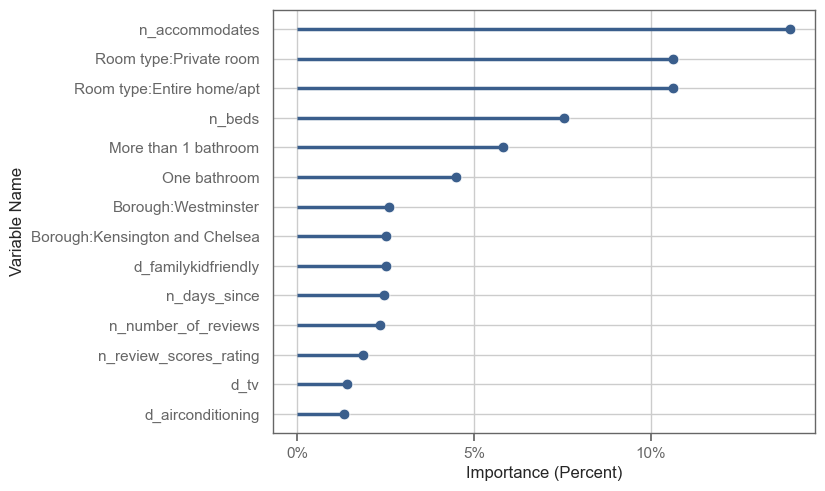

In [29]:
cutoff = 0.013

plot_df = rf_model_2_var_imp_df.loc[lambda x: x.imp > cutoff]
da_variable_importance_plot(plot_df)

**2) full varimp plot, top 10 only**

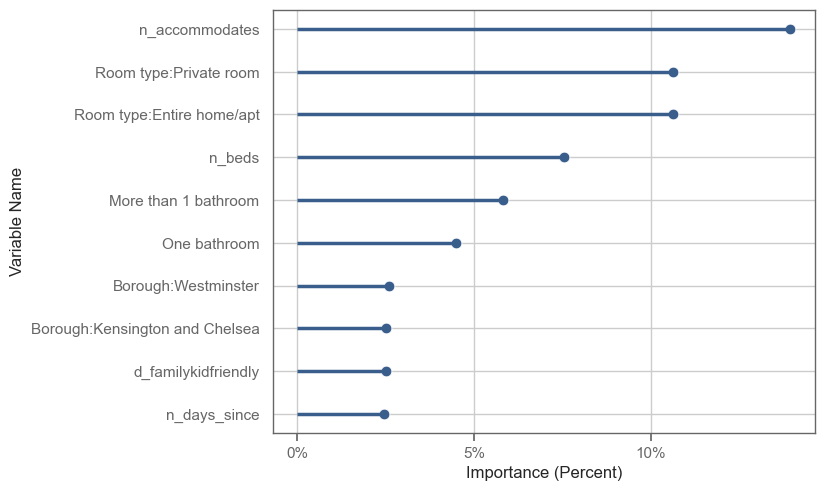

In [30]:
plot_df = rf_model_2_var_imp_df.head(10)
da_variable_importance_plot(plot_df)

#### 3) grouped variable importance - keep binaries created off factors together

First we do this by summing up the individual importances of factors - this is not correct, but it's in the first edition.

Simply summing up the individual importances of each dummy could underestimate the importance of the qualitative variable. This occurs because omitting a single category might not significantly impact performance as the remaining correlated categories can still provide the model with the necessary information. 

To address this issue, we need to assess the impact of including the entire categorical variable, not just the individual dummies. We create a pipeline which first encodes the categorical variables into dummy variables, then trains the model on the encoded data. Finally, we can employ a model-agnostic feature importance technique on this entire pipeline to estimate the contribution of each variable. This way, one categorical variableis either included or not during the calculation of variable importances.
 
Model-agnostic feature importance techniques are methods used to determine the importance of features in a model, regardless of the model type. These techniques work by assessing the impact of each feature on the model's predictions without relying on the internal workings of the model. One such technique is permutation feature importance, which randomly shuffles the values of variables and measures how much the fit of the prediction is decreased.

In [31]:
rf_model_2_var_imp_df_grouped = (
    pd.DataFrame(
        [rf_model_2.best_estimator_.feature_importances_, X.columns],
        index=["imp", "varname"],
    )
    .T.assign(
        varname=lambda x: np.where(
            x["varname"].str.contains("cat__"),
            x["varname"].str.split("_").str[:-1].str.join("_"),
            x["varname"],
        )
    )
    .assign(
        varname=lambda x: x["varname"].str.replace("cat__", "").str.replace("num__", "")
    )
    .groupby("varname")[["imp"]]
    .sum()
    .reset_index()
    .assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())
)

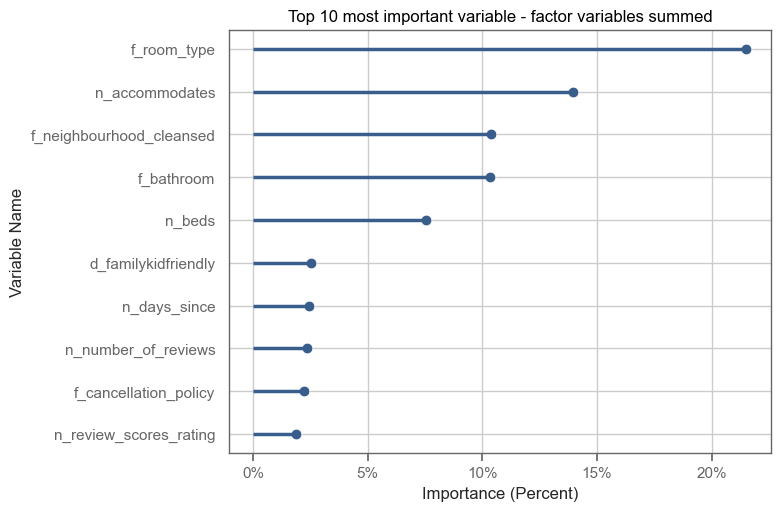

In [32]:
plot_df = rf_model_2_var_imp_df_grouped.sort_values(by=["imp"], ascending=False).head(10)
da_variable_importance_plot(
    plot_df, title="Top 10 most important variable - factor variables summed"
)

**OneHotEncoding and training the RandomForest model in a pipeline and calculating permutation importance - second edition**

In [33]:
rf_best_pipeline = Pipeline(
    [
        ("preprocess", preprocessor),
        ("regressor", rf_model_2.best_estimator_),  # put best model to pipeline
    ]
)

In [34]:
rf_best_pipeline.fit(data_train[predictors_2], data_train.price)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat', OneHotEncoder(),
                                                  ['f_property_type',
                                                   'f_room_type', 'f_bathroom',
                                                   'f_cancellation_policy',
                                                   'f_bed_type',
                                                   'f_neighbourhood_cleansed']),
                                                 ('num', 'passthrough',
                                                  ['n_accommodates', 'n_beds',
                                                   'n_days_since',
                                                   'n_number_of_reviews',
                                                   'flag_n_number_of_reviews',
                                                   'n_review_scores_rating',
                                                   'flag_review_sco...
                                                   'd_doormanentry', 'd_dryer',
                                                   'd_elevatorinbuilding',
                                                   'd_essentials',
                                                   'd_familykidfriendly',
                                                   'd_fireextinguisher',
                                                   'd_firstaidkit',
                                                   'd_freeparkingonpremises',
                                                   'd_freeparkingonstreet',
                                                   'd_gym', 'd_hairdryer',
                                                   'd_hangers', 'd_heating',
                                                   'd_hottub', ...])])),
                ('regressor',
                 RandomForestRegressor(max_features=12, min_samples_split=6,
                                       n_estimators=30, n_jobs=7,
                                       oob_score=True, random_state=42))])

In [35]:
# This takes a while
result = permutation_importance(
    rf_best_pipeline,
    data_train[predictors_2],
    data_train.price,
    n_repeats=10,
    random_state=45,
    n_jobs=-1,
)


In [36]:
grouped_imp = pd.DataFrame(
    [result.importances_mean, data_train[predictors_2].columns],
    index=["imp", "varname"],
).T.assign(imp_percentage=lambda x: x["imp"] / x["imp"].sum())

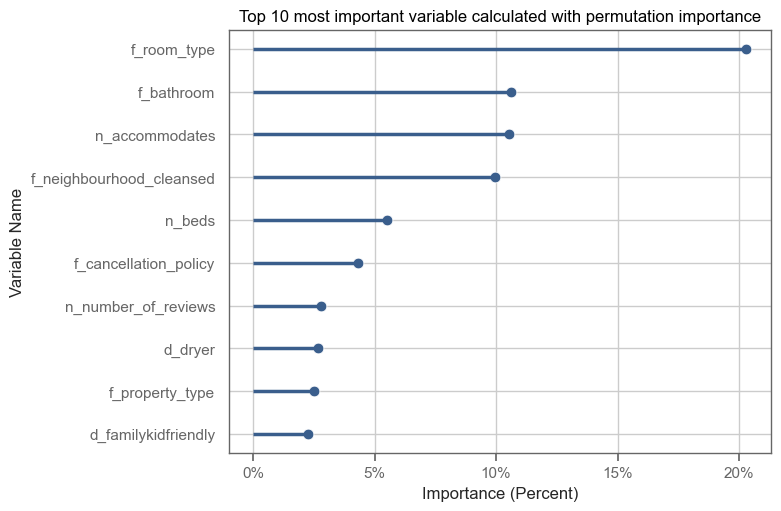

In [37]:
plot_df = grouped_imp.sort_values(by=["imp"], ascending=False).head(10)
da_variable_importance_plot(
    plot_df,
    title="Top 10 most important variable calculated with permutation importance",
)

## Partial Dependence Plots 
-------------------------------------------------------


In [38]:
def set_ylim_for_pdp(pdp_results: pd.DataFrame):
    ymax = math.ceil(pdp_results["average"].max() / 10) * 10
    ymin = math.floor(pdp_results["average"].min() / 10) * 10
    plt.ylim(ymin, ymax)
    plt.yticks(np.arange(ymin, ymax + 1, 10))


def da_plot_partial_dependence(model, data: pd.DataFrame, variable: str, varlabel: str):

    pdp_results = partial_dependence(model, data, [variable], kind="average")

    pdp_results = pd.DataFrame(
        [pdp_results["average"][0], pdp_results["values"][0]],
        index=["average", "values"],
    ).T

    if pdp_results["values"].dtype == "object":
        linestyle = "none"
    else:
        linestyle = "-"

    sns.pointplot(
        data=pdp_results, x="values", y="average", scale=0.8, linestyle=linestyle
    )
    set_ylim_for_pdp(pdp_results)
    plt.grid(axis="x", linestyle="-", alpha=0.7)
    plt.xlabel(varlabel)
    plt.ylabel("Predicted price")
    plt.show()

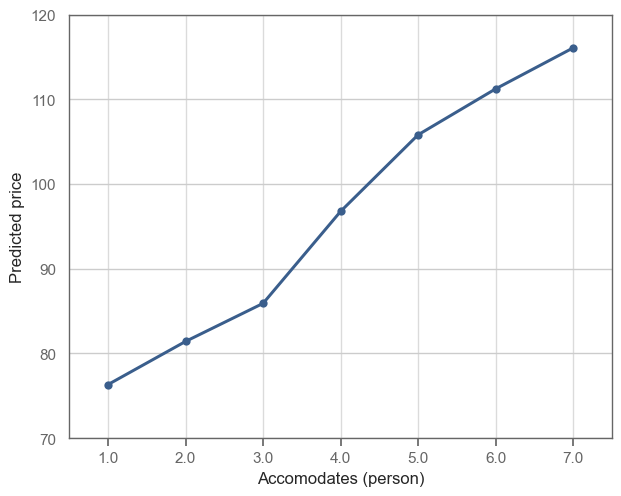

In [39]:
da_plot_partial_dependence(
    rf_best_pipeline,
    data_holdout[predictors_2],
    "n_accommodates",
    "Accomodates (person)",
)

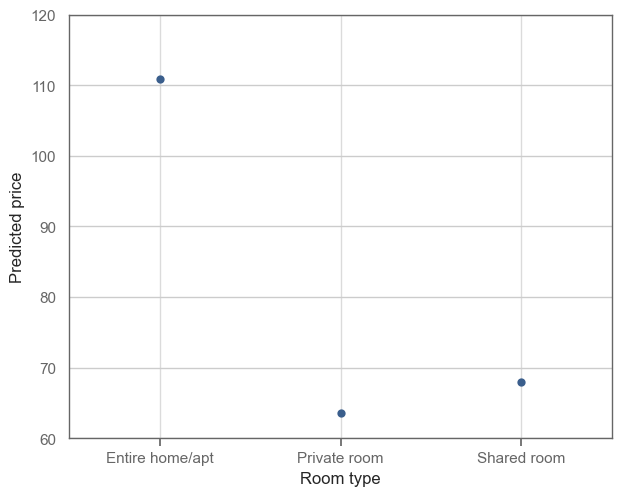

In [40]:
da_plot_partial_dependence(
    rf_best_pipeline, data_holdout[predictors_2], "f_room_type", "Room type"
)

### Subsample performance: RMSE / mean(y) 
---------------------------------------
NOTE  we do this on the holdout set.


In [41]:
data_holdout_w_prediction = data_holdout.assign(
    predicted_price=rf_best_pipeline.predict(data_holdout[predictors_2])
)


create nice summary table of heterogeneity

In [42]:
def calculate_rmse(groupby_obj):
    return (
        groupby_obj.apply(
            lambda x: root_mean_squared_error(x.predicted_price, x.price),
        )
        .to_frame(name="rmse")
        .assign(mean_price=groupby_obj.apply(lambda x: np.mean(x.price)).values)
        .assign(rmse_norm=lambda x: x.rmse / x.mean_price)
        .round(2)
    )

In [43]:
# cheaper or more expensive flats - not used in book
grouped_object = data_holdout_w_prediction.assign(
    is_low_size=lambda x: np.where(x.n_accommodates <= 3, "small apt", "large apt")
).groupby("is_low_size")
accom_subset = calculate_rmse(grouped_object)


In [44]:
grouped_object = data_holdout_w_prediction.loc[
    lambda x: x.f_neighbourhood_cleansed.isin(
        [
            "Westminster",
            "Camden",
            "Kensington and Chelsea",
            "Tower Hamlets",
            "Hackney",
            "Newham",
        ]
    )
].groupby("f_neighbourhood_cleansed")
neightbourhood_subset = calculate_rmse(grouped_object)


In [45]:
grouped_object = data_holdout_w_prediction.loc[
    lambda x: x.f_property_type.isin(["Apartment", "House"])
].groupby("f_property_type")
proptype_subset = calculate_rmse(grouped_object)


In [46]:
all_holdout = (
    pd.DataFrame(
        [
            root_mean_squared_error(
                data_holdout_w_prediction.price,
                data_holdout_w_prediction.predicted_price,
            ),
            data_holdout_w_prediction.price.mean(),
        ],
        index=["rmse", "mean_price"],
    )
    .T.assign(rmse_norm=lambda x: x.rmse / x.mean_price)
    .round(2)
)
all_holdout.index = ["All"]

In [47]:
type_rows = pd.DataFrame(
    None,
    index=["Apartment size", "Type", "Borough"],
    columns=["rmse", "mean_price", "rmse_norm"],
).fillna("")


### Table 16.2 Performance across subsamples

In [48]:
pd.concat(
    [
        type_rows.iloc[[0]],
        accom_subset,
        type_rows.iloc[[1]],
        proptype_subset,
        type_rows.iloc[[2]],
        neightbourhood_subset,
        all_holdout,
    ]
)


,rmse,mean_price,rmse_norm
Apartment size,,,
large apt,65.97,144.06,0.46
small apt,31.15,62.86,0.5
Type,,,
Apartment,43.54,93.19,0.47
House,50.74,77.49,0.65
Borough,,,
Camden,52.6,105.01,0.5
Hackney,38.86,76.05,0.51
Kensington and Chelsea,66.05,143.55,0.46


## SHAP

In [49]:
import shap

In [51]:
X_holdout = preprocessor.fit_transform(data_holdout[predictors_2])
X_holdout = pd.DataFrame(X_holdout, columns=preprocessor.get_feature_names_out())

Calculate SHAP values for our best model

**NOTE:** Again, we do this on the holdout set!

In [52]:
explainer = shap.Explainer(rf_best_pipeline["regressor"].predict, X_holdout)
shap_values = explainer(X_holdout)

PermutationExplainer explainer: 14949it [13:08, 18.75it/s]                           


### Beeswarm plot of SHAP values

The beeswarm plot is designed to display an information-dense summary of how the top features in a dataset impact the model’s output. Each instance the given explanation is represented by a single dot on each feature row. The x position of the dot is determined by the SHAP value of that feature, and dots “pile up” along each feature row to show density. Color is used to display the original value of a feature. In the plot below we can see that Entire home/apt is the most important feature on average, and than Entire home/apt-s are more expensive.



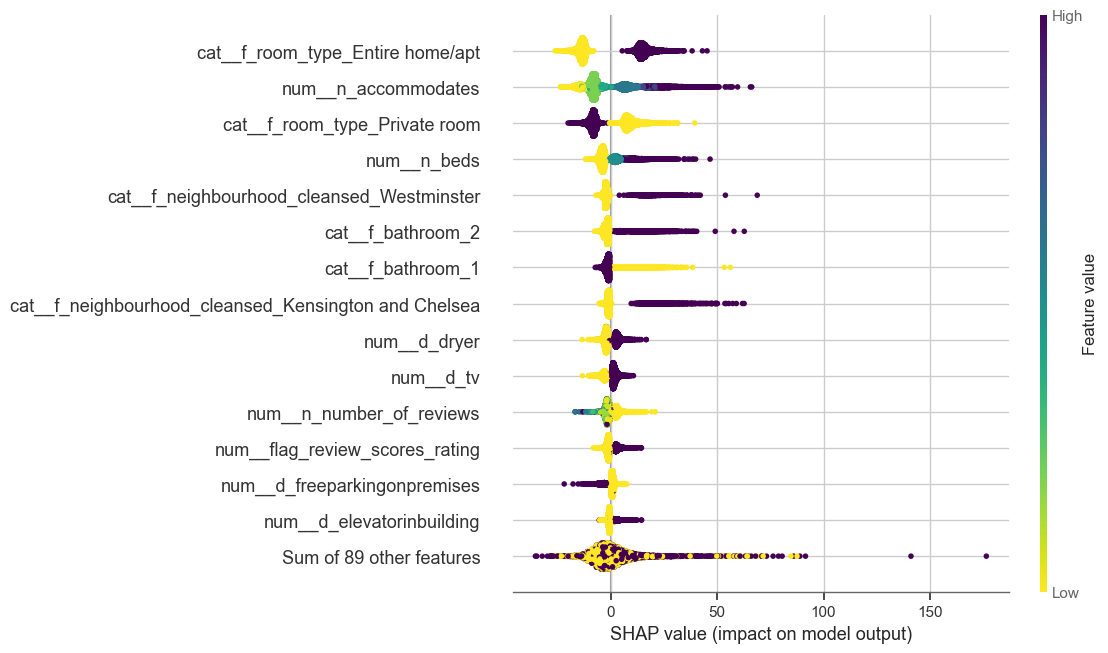

In [53]:
shap.plots.beeswarm(shap_values, max_display = 15, color=plt.get_cmap("viridis_r"),show=True)

Can do the same with **SHAP values scaled log**. This might come handy, when the distribution of SHAP values are skewed

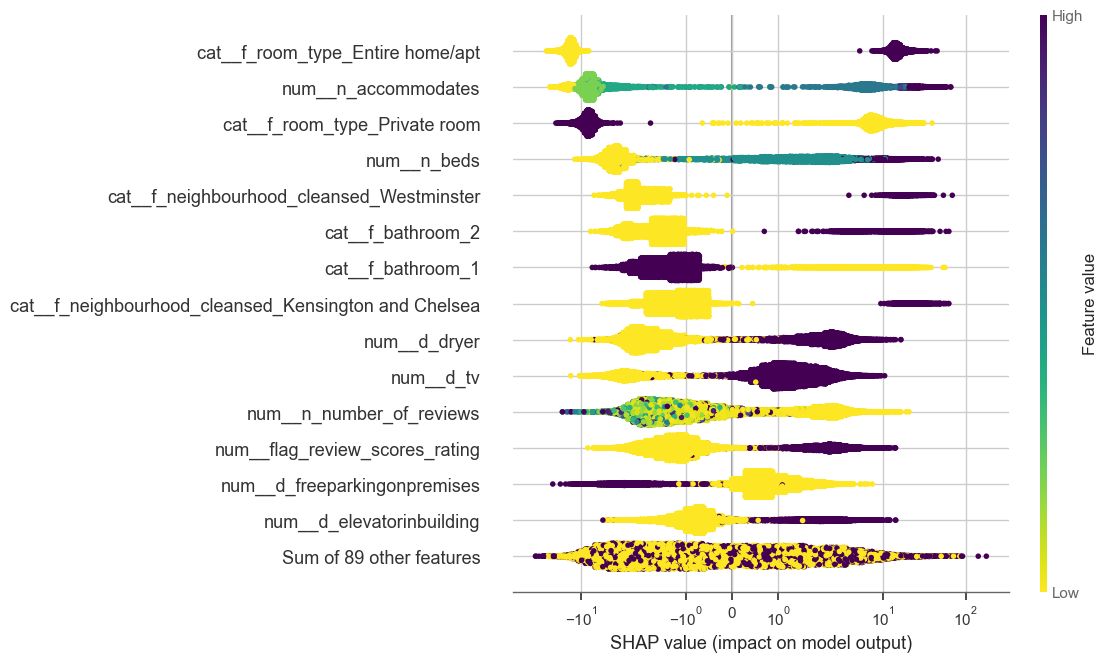

In [54]:
shap.plots.beeswarm(
    shap_values, max_display=15, log_scale=True, color=plt.get_cmap("viridis_r")
)

You can also display the **SHAP values in absolute**, on a beeswarm plot

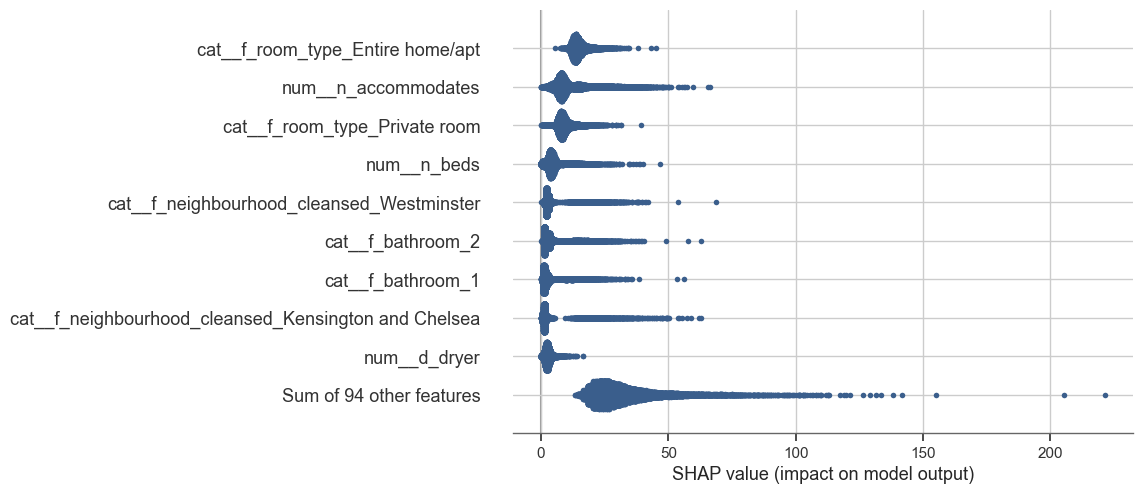

In [55]:
shap.plots.beeswarm(shap_values.abs, color=color[0])

Or on a barplot

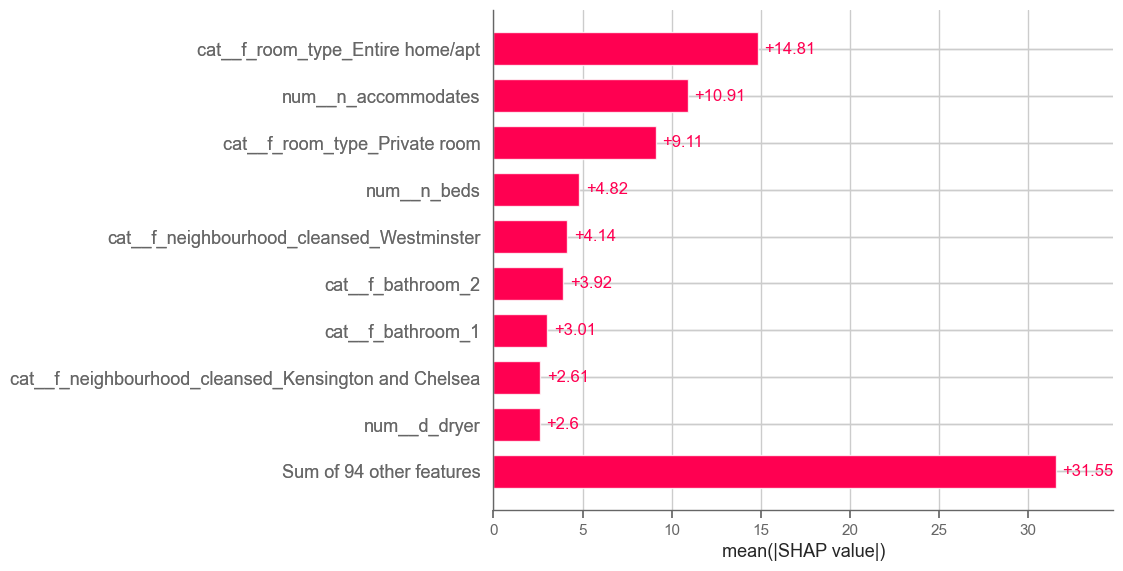

In [56]:
shap.plots.bar(shap_values)

### Explanining predictions for a unit of observation (airbnb)

Let's look at SHAP values for the third observation in the holdout set. 

- .values array contains the shap values
- .base_values contains the expected value (intercept/constant in OLS terms)
- .data contains the feature values for the observation

In [57]:
shap_values[2]

.values =
array([-9.58202347e-01, -3.86738586e-01,  1.22337452e+01,  9.09076170e+00,
        0.00000000e+00, -2.05555556e-03, -1.66819850e+00, -3.59072261e+00,
        1.05571664e+00, -1.26833756e+00, -2.00030358e+00,  3.03242094e-02,
        3.76692130e-02,  1.44444444e-03,  2.52569444e-02,  0.00000000e+00,
        2.04855159e-02,  7.02460317e-03, -2.08585717e-01,  0.00000000e+00,
        2.95443783e-02,  1.12192460e-02, -4.49722222e-03,  0.00000000e+00,
       -2.91582822e-02, -1.75357970e-01,  7.17553571e-02,  0.00000000e+00,
        0.00000000e+00,  1.11061508e-02, -3.54011574e-02, -4.99199946e-02,
       -8.31967585e-01,  0.00000000e+00,  6.36460137e-02,  2.81345569e-02,
       -9.54955357e-02, -1.52662037e-02,  1.02083333e-03, -8.14884470e-02,
       -1.08125120e-02,  0.00000000e+00,  6.66119131e-02,  4.31687259e-02,
       -8.08799393e-02,  1.82766595e+01, -8.92257498e+00, -3.39310695e+00,
       -4.15847946e-01, -8.81791493e-01,  0.00000000e+00, -2.00923150e+00,
       -1.79019

#### Waterfall plot
The waterfall plot shows how the sum of all the SHAP values equals the difference between the prediction $f(x)$ and the expected value $E[f(x)]$. Waterfall plots are designed to display explanations for individual predictions, so they expect a single row of an Explanation object as input. The bottom of a waterfall plot starts as the expected value of the model output, and then each row shows how the positive (red) or negative (blue) contribution of each feature moves the value from the expected model output over the background dataset to the model output for this prediction.

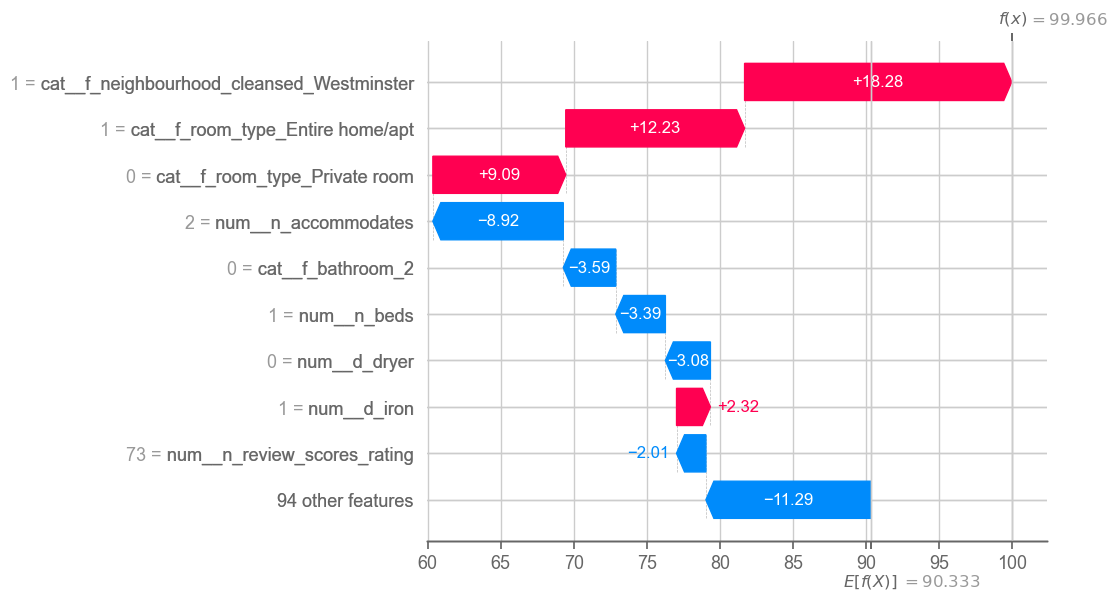

In [58]:
shap.plots.waterfall(shap_values[2])

Same plot, but SHAP values for another observation below.

Note, that for a same predictor (eg. f_room_type_Private room = 0) the SHAP values are different for the airbnb above (+5.29) and above (+6.88).

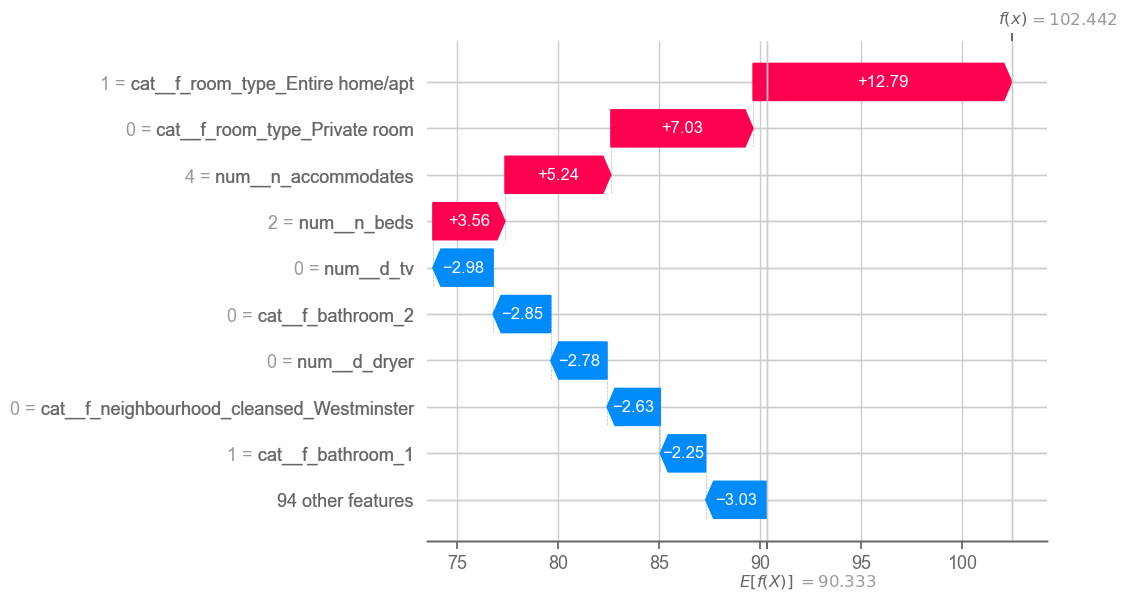

In [59]:
shap.plots.waterfall(shap_values[3])

## Lime


In [204]:
feature_names = categorical_columns + numerical_columns
categorical_features = list(range(0,6)) + [10] + list(range(12,63))
numerical_features = [6,7,8,9,11]

data_train_lime = data_train.filter(feature_names).copy()
data_holdout_lime = data_holdout.filter(feature_names).copy()


categorical_names = {}
for i, feature in enumerate(data_train_lime.iloc[:,categorical_features].columns):
    le = LabelEncoder()
    le.fit(data_train_lime.loc[:, feature])
    data_train_lime.loc[:, feature] = le.transform(data_train_lime.loc[:, feature])
    data_holdout_lime.loc[:, feature] = le.transform(data_holdout_lime.loc[:, feature])
    categorical_names[i] = list(le.classes_)

data_train_lime = data_train_lime.astype(float)
data_holdout_lime = data_holdout_lime.astype(float)

In [205]:
#categorical_features = list(range(0, 6))
#numerical_features = list(range(6, 63))

categorical_encoder = OneHotEncoder(
    handle_unknown="ignore",
    drop="if_binary",
)

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_features),
        ("num", "passthrough", numerical_features),
    ]
)

rf_best_pipeline = Pipeline(
    [
        ("preprocess", preprocessing),
        ("regressor", rf_model_2.best_estimator_),  # put best model to pipeline
    ]
)

In [206]:
rf_best_pipeline.fit(data_train_lime, data_train.price)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'),
                                                  [0, 1, 2, 3, 4, 5, 10, 12, 13,
                                                   14, 15, 16, 17, 18, 19, 20,
                                                   21, 22, 23, 24, 25, 26, 27,
                                                   28, 29, 30, 31, 32, 33, 34, ...]),
                                                 ('num', 'passthrough',
                                                  [6, 7, 8, 9, 11])])),
                ('regressor',
                 RandomForestRegressor(max_features=12, min_samples_split=6,
                                       n_estimators=30, n_jobs=7,
                                       oob_score=True, random_state=42))])

In [207]:
predict_fn = lambda x: rf_best_pipeline["regressor"].predict(rf_best_pipeline["preprocess"].transform(x)).astype(float)

In [208]:
instance = data_holdout_lime.iloc[[2]]

In [209]:
from lime.lime_tabular import LimeTabularExplainer

random_seed = 1237


explainer = LimeTabularExplainer(
    data_holdout_lime.values,
    feature_names=data_holdout_lime.columns,
    categorical_features=categorical_features,
    categorical_names=categorical_names,
    mode="regression",
    random_state=random_seed,
)

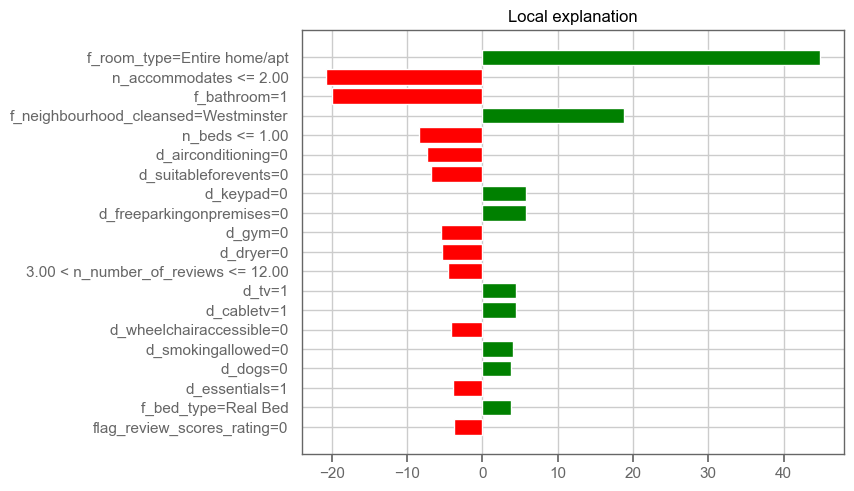

In [210]:
from sklearn.linear_model import Ridge

exp = explainer.explain_instance(
    instance.values[0],
    predict_fn,
    num_features=20,
    num_samples=1000,
    distance_metric="euclidean",
    model_regressor=Ridge(
        alpha=1, fit_intercept=True, random_state=explainer.random_state
    ),
)

exp.as_pyplot_figure()
plt.show()

In [211]:
exp.predicted_value

100.82125541125541

In [212]:
exp.local_pred[0]

106.46339905389821

In [213]:
exp.intercept[0]

101.00516254930582

In [214]:
sum([i[1] for i in exp.as_list()])

5.45823650459239

## Interactions

Look at interactions from `ch14-airbnb-reg`

In [151]:
(
    "f_room_type*d_familykidfriendly",
    "f_room_type*f_property_type",
    "f_property_type*d_airconditioning",
    "f_property_type*d_cats",
    "f_property_type*d_dogs",
)

('f_room_type*d_familykidfriendly',
 'f_room_type*f_property_type',
 'f_property_type*d_airconditioning',
 'f_property_type*d_cats',
 'f_property_type*d_dogs')

To help reveal these interactions we can color by another feature. If we pass the whole explanation tensor to the color argument **the scatter plot will pick the best feature to color by.**

Get best proposed interaction by SHAP values for room types. Note that the grey area on the plot corresponds to the distribution of the feature in the data.

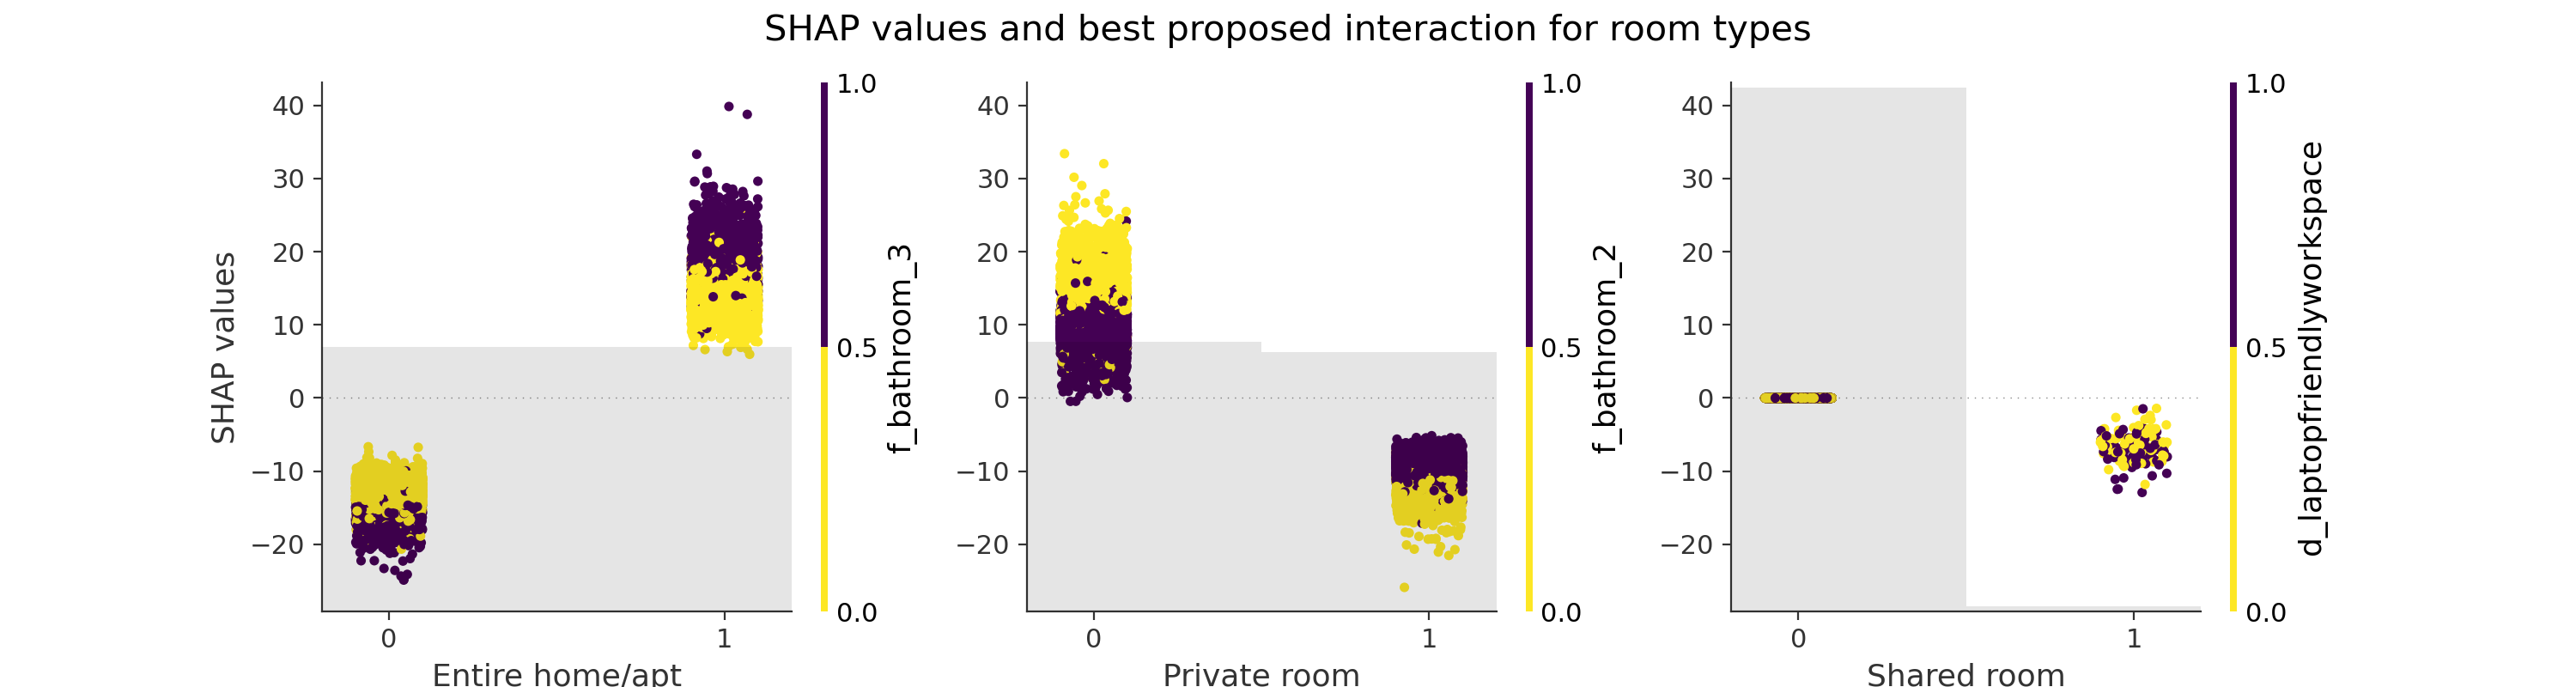

In [154]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
fig.suptitle(
    "SHAP values and best proposed interaction for room types",
    fontsize=15,
)
shap.plots.scatter(
    shap_values[:, "f_room_type_Entire home/apt"],
    color=shap_values,
    show=False,
    cmap=plt.get_cmap("viridis_r"),
    ax=ax1,
)
plt.ylabel("SHAP values")
plt.xlabel("Entire home/apt")
plt.xlim(-0.2, 1.2)
plt.xticks((0, 1), labels=(0, 1))
shap.plots.scatter(
    shap_values[:, "f_room_type_Private room"],
    color=shap_values,
    show=False,
    cmap=plt.get_cmap("viridis_r"),
    ax=ax2,
)
plt.ylabel(None)
plt.xlabel("Private room")
plt.xlim(-0.2, 1.2)
plt.xticks((0, 1), labels=(0, 1))
shap.plots.scatter(
    shap_values[:, "f_room_type_Shared room"],
    color=shap_values,
    show=False,
    cmap=plt.get_cmap("viridis_r"),
    ax=ax3,
)
plt.ylabel(None)
plt.xlabel("Shared room")
plt.xlim(-0.2, 1.2)
plt.xticks((0, 1), labels=(0, 1))
plt.show()

It turned out, that for the `f_room_type` variable the best interaction (at least based on RF and SHAP) would be the `f_bathroom` which we did not choose in ch14.

Let's check for `d_airconditioning`, `d_dogs` and `d_cats`.

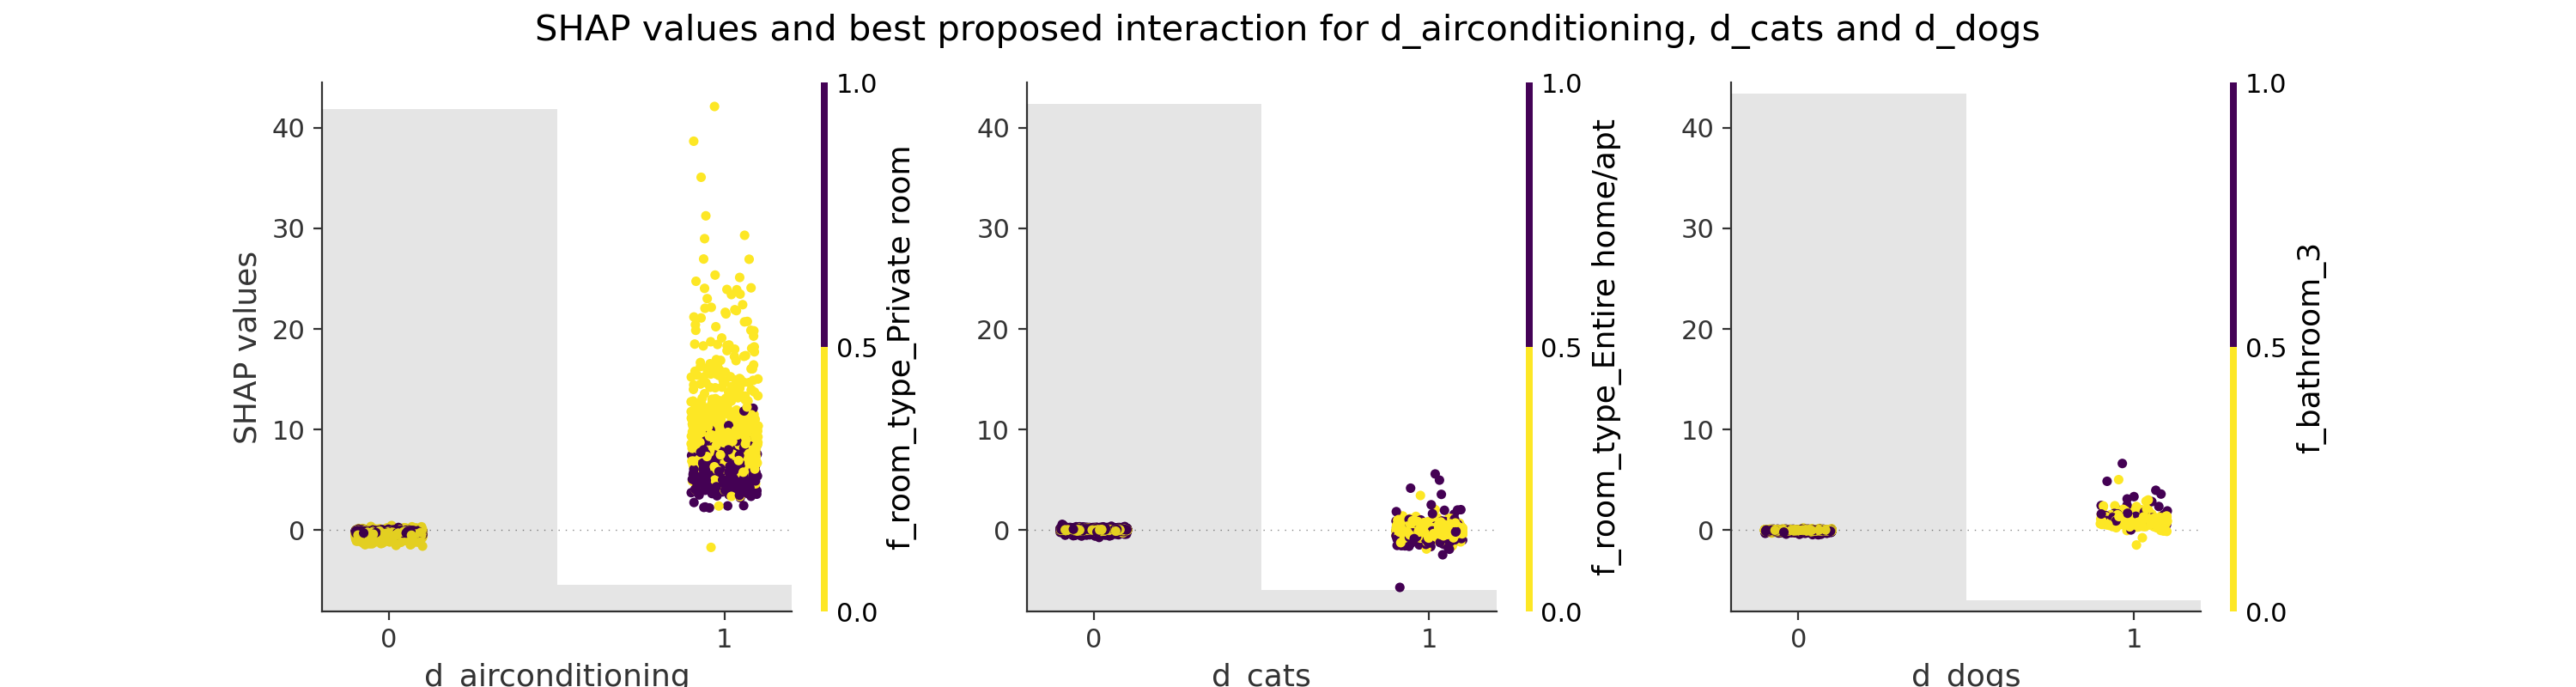

In [157]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
fig.suptitle(
    "SHAP values and best proposed interaction for d_airconditioning, d_cats and d_dogs",
    fontsize=15,
)
shap.plots.scatter(
    shap_values[:, "d_airconditioning"],
    color=shap_values,
    show=False,
    cmap=plt.get_cmap("viridis_r"),
    ax=ax1,
)
plt.ylabel("SHAP values")
plt.xlim(-0.2, 1.2)
plt.xticks((0, 1), labels=(0, 1))
shap.plots.scatter(
    shap_values[:, "d_cats"],
    color=shap_values,
    show=False,
    cmap=plt.get_cmap("viridis_r"),
    ax=ax2,
)
plt.ylabel(None)
plt.xlim(-0.2, 1.2)
plt.xticks((0, 1), labels=(0, 1))
shap.plots.scatter(
    shap_values[:, "d_dogs"],
    color=shap_values,
    show=False,
    cmap=plt.get_cmap("viridis_r"),
    ax=ax3,
)
plt.ylabel(None)
plt.xlim(-0.2, 1.2)
plt.xticks((0, 1), labels=(0, 1))
plt.show()

The distribution in grey is switched off

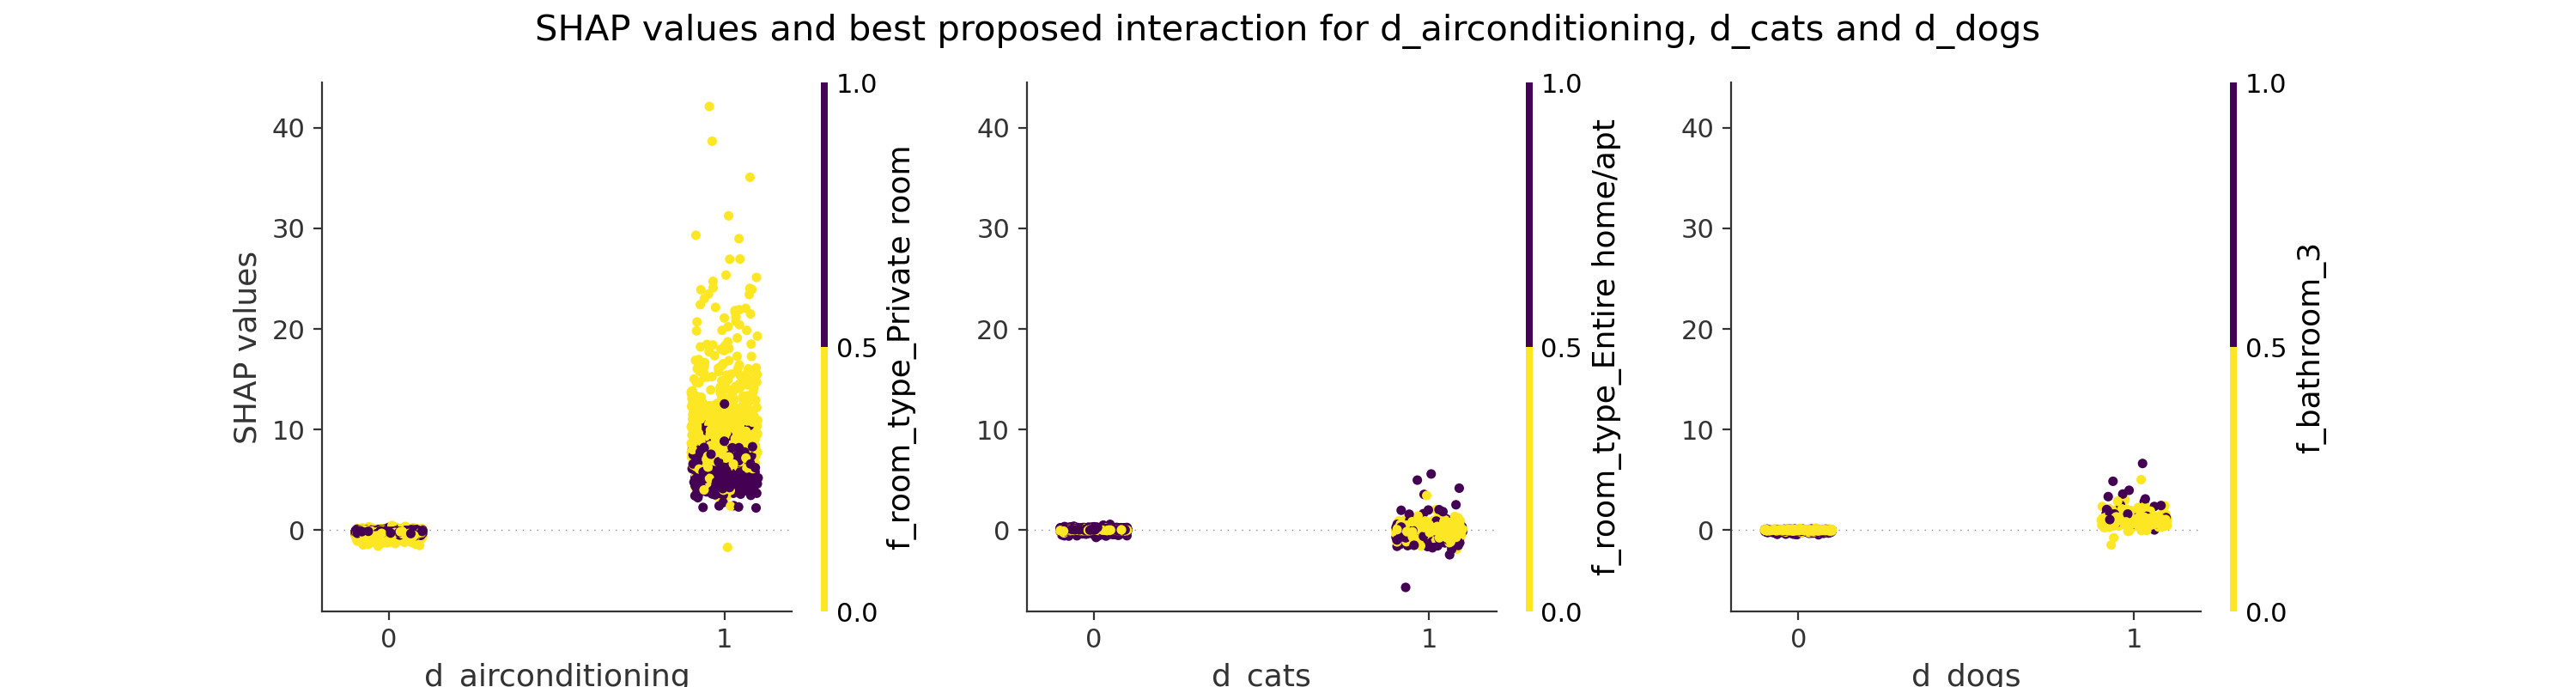

In [160]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4), sharey=True)
fig.suptitle(
    "SHAP values and best proposed interaction for d_airconditioning, d_cats and d_dogs",
    fontsize=15,
)
shap.plots.scatter(
    shap_values[:, "d_airconditioning"],
    color=shap_values,
    show=False,
    hist=False,
    cmap=plt.get_cmap("viridis_r"),
    ax=ax1,
)
plt.ylabel("SHAP values")
plt.xlim(-0.2, 1.2)
plt.xticks((0, 1), labels=(0, 1))
shap.plots.scatter(
    shap_values[:, "d_cats"],
    color=shap_values,
    show=False,
    hist=False,
    cmap=plt.get_cmap("viridis_r"),
    ax=ax2,
)
plt.ylabel(None)
plt.xlim(-0.2, 1.2)
plt.xticks((0, 1), labels=(0, 1))
shap.plots.scatter(
    shap_values[:, "d_dogs"],
    color=shap_values,
    show=False,
    hist=False,
    cmap=plt.get_cmap("viridis_r"),
    ax=ax3,
)
plt.ylabel(None)
plt.xlim(-0.2, 1.2)
plt.xticks((0, 1), labels=(0, 1))
plt.show()

Take a look at a discrete feature, `n_accommodates`

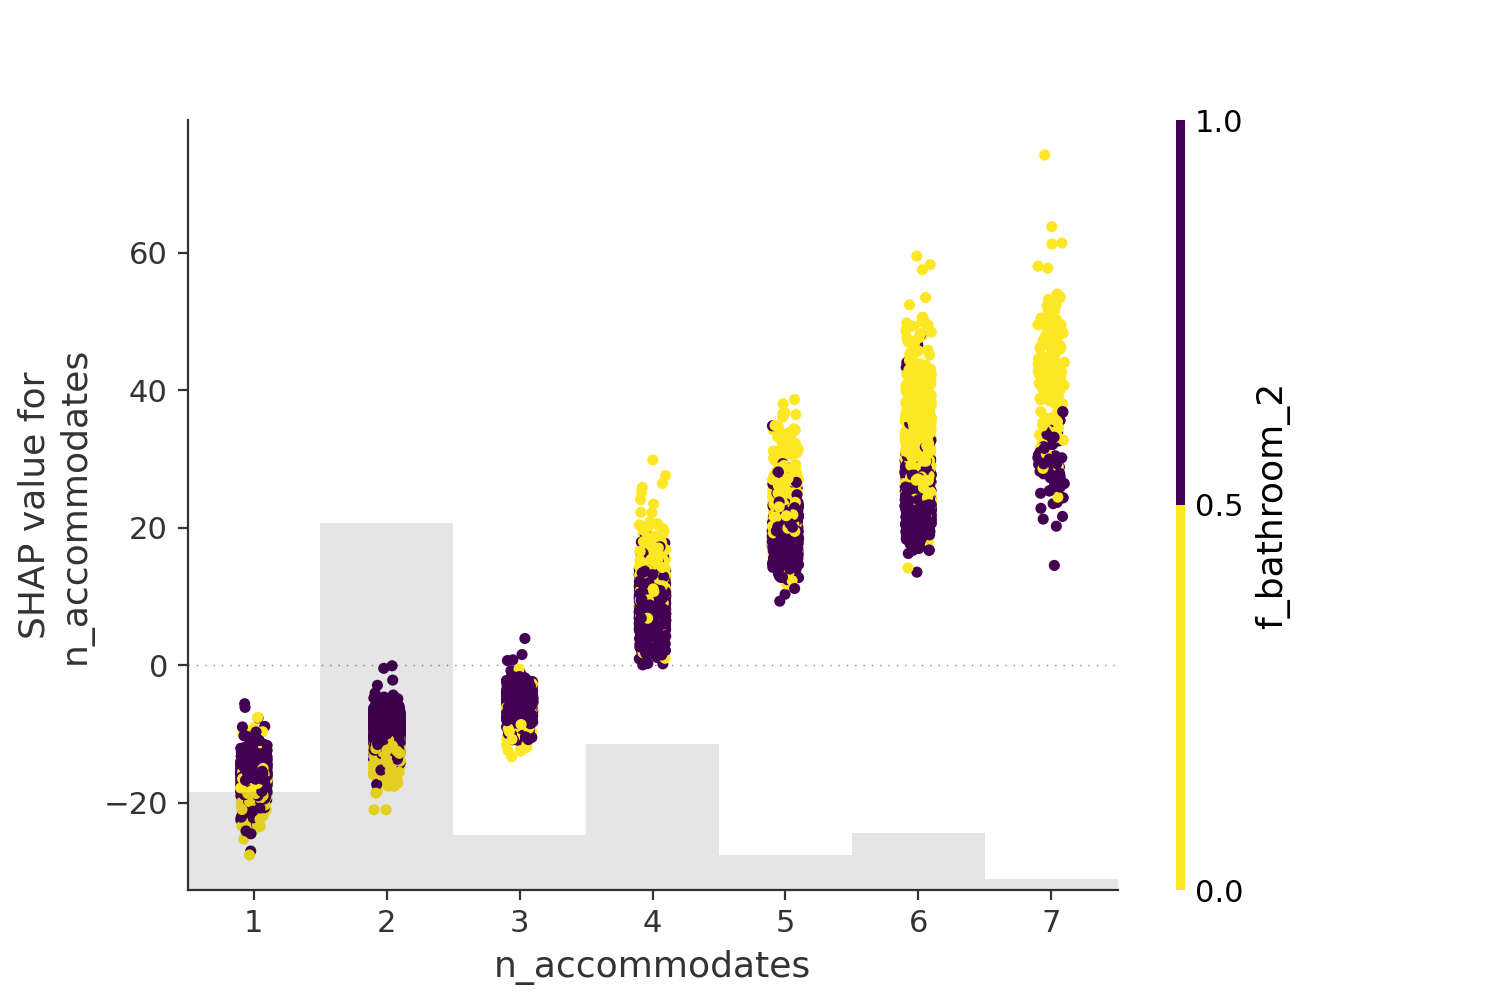

In [163]:
shap.plots.scatter(
    shap_values[:, "n_accommodates"], color=shap_values, cmap=plt.get_cmap("viridis_r")
)

## PART IV
### HORSERACE: compare with other models 
-----------------------------------------------

1. OLS with dummies for area

 using model B

In [56]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)

ols_model = LinearRegression().fit(X, y)

# y_test, X_test = dmatrices("price ~ " + " + ".join(predictors_2), data_holdout)

y_hat = ols_model.predict(X)

ols_rmse = root_mean_squared_error(y, y_hat)
ols_rmse


47.080724282174636

In [57]:
ols_model_coeffs_df = pd.DataFrame(
    ols_model.coef_.tolist()[0],
    index=X.design_info.column_names,
    columns=["ols_coefficient"],
).assign(ols_coefficient=lambda x: x.ols_coefficient.round(3))


In [58]:
ols_model_coeffs_df


,ols_coefficient
Intercept,-0.000
f_property_type[T.House],7.162
f_room_type[T.Private room],-35.093
f_room_type[T.Shared room],-44.506
f_cancellation_policy[T.moderate],-1.305
...,...
d_tv,6.042
d_washer,-4.659
d_washerdryer,73.814
d_wheelchairaccessible,-1.948


2.  LASSO

using extended model w interactions

The parameter l1_ratio corresponds to alpha in the glmnet R package while alpha corresponds to the lambda parameter in glmnet. Specifically, l1_ratio = 1 is the lasso penalty. Currently, l1_ratio <= 0.01 is not reliable, unless you supply your own sequence of alpha.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

In [60]:
lasso_model = ElasticNet(l1_ratio=1, fit_intercept=True)


In [61]:
lasso_model_cv = GridSearchCV(
    lasso_model,
    {"alpha": [i / 100 for i in range(1, 26, 1)]},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)


In [62]:
y, X = dmatrices("price ~ " + " + ".join(predictors_E), data_train)


In [63]:
lasso_model_cv.fit(X, y.ravel())


In [64]:
pd.DataFrame(
    lasso_model_cv.best_estimator_.coef_.tolist(),
    index=X.design_info.column_names,
    columns=["lasso_coefficient"],
).assign(lasso_coefficient=lambda x: x.lasso_coefficient.round(3)).loc[
    lambda x: x.lasso_coefficient != 0
]


,lasso_coefficient
f_property_type[T.House],-0.656
f_room_type[T.Private room],-34.872
f_room_type[T.Shared room],-44.165
f_cancellation_policy[T.moderate],-1.249
f_cancellation_policy[T.strict],4.837
...,...
d_tv,5.855
d_washer,-4.515
d_washerdryer,66.270
d_wheelchairaccessible,-0.856


In [65]:
lasso_rmse = (
    pd.DataFrame(lasso_model_cv.cv_results_)
    .loc[lambda x: x.param_alpha == lasso_model_cv.best_estimator_.alpha]
    .mean_test_score.values[0]
    * -1
)
lasso_rmse


45.942508094434835

3. CART model

In [67]:
y, X = dmatrices("price ~ " + " + ".join(predictors_2), data_train)


In [68]:
cart_model = DecisionTreeClassifier(random_state=2018, criterion="gini")


In [69]:
# Get potential ccp_alpha parameters

path = cart_model.cost_complexity_pruning_path(X, y.ravel())
ccp_alphas, impurities = path.ccp_alphas, path.impurities


In [70]:
# apply random search to select a "best" alpha
# RandomizedSearchCV does not calculate all potential alphas, just a random subset

cart_model_cv = RandomizedSearchCV(
    cart_model,
    {"ccp_alpha": ccp_alphas},
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=3,
)


cart_model_cv.fit(X, y.ravel())


In [71]:
cart_rmse = (
    pd.DataFrame(cart_model_cv.cv_results_)
    .loc[lambda x: x.param_ccp_alpha == cart_model_cv.best_estimator_.ccp_alpha]
    .mean_test_score.values[0]
    * -1
)
cart_rmse


56.35208434295712

4. GBM

**NOTE:** These models run for a **very long time** -- needs further investigations.

In [ ]:
gbm = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=20)

tune_grid = {"n_estimators": [i for i in range(200, 500, 50)], "max_depth": [1, 5, 10]}

gbm_model_cv = GridSearchCV(
    gbm, tune_grid, cv=5, scoring="neg_root_mean_squared_error", verbose=10, n_jobs=-1
)


In [ ]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv)], verbose=True
)


In [ ]:
gbm_pipe.fit(data_train[predictors_2], data_train.price)


In [82]:
gbm_rmse = gbm_pipe.steps[-1][1].best_score_ * -1

the next will be in final model, loads of tuning

In [ ]:
gbm_broad = GradientBoostingRegressor()


In [ ]:
tune_grid = {
    "n_estimators": [i for i in range(50, 500, 50)],
    "max_depth": [1, 5, 10],
    "learning_rate": [0.02, 0.05, 0.1, 0.15, 0.2],
    "min_samples_split": [5, 10, 20, 30],
}

gbm_model_cv_broad = GridSearchCV(
    gbm_broad,
    tune_grid,
    cv=5,
    scoring="neg_root_mean_squared_error",
    verbose=10,
)


In [ ]:
categorical_columns = [col for col in predictors_2 if col.startswith("f_")]
numerical_columns = [col for col in predictors_2 if col not in categorical_columns]

categorical_encoder = OneHotEncoder(handle_unknown="ignore")

preprocessing = ColumnTransformer(
    [
        ("cat", categorical_encoder, categorical_columns),
        ("num", "passthrough", numerical_columns),
    ]
)

gbm_pipe_broad = Pipeline(
    [("preprocess", preprocessing), ("regressor", gbm_model_cv_broad)], verbose=True
)


In [ ]:
gbm_pipe_broad.fit(data_train[predictors_2], data_train.price)


In [ ]:
gbm_broad_rmse = gbm_pipe_broad.steps[-1][1].best_score_ * -1

### Table 16.3 Predictive performance of different models

In [89]:
pd.DataFrame(
    {
        "Model": [
            "Linear regression (OLS)",
            "Linear regression (LASSO)",
            "Regression Tree (CART)",
            "Random forest (basic tuning)",
            "Random forest (autotuned)",
            "GBM (basic tuning)",
            "GBM (broad tuning)",
        ],
        "RMSE": [
            ols_rmse,
            lasso_rmse,
            cart_rmse,
            rf_model_1_rmse,
            rf_model_2_rmse,
            gbm_rmse,
            gbm_broad_rmse,
        ],
    }
).round(1)

,Model,RMSE
0,Linear regression (OLS),47.1
1,Linear regression (LASSO),45.9
2,Regression Tree (CART),56.4
3,Random forest (basic tuning),45.8
4,Random forest (autotuned),45.0
5,GBM (basic tuning),43.8
6,GBM (broad tuning),43.6
